In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
from tqdm.notebook import tqdm

import ElementsEnv
%erun PHZ_NNPZ 0.12.5

from nnpz.framework.NeighborSet import NeighborSet

%load_ext autoreload
%autoreload 2
from associative import AssociativeArray

In [2]:
ref = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_Prod_02jun21_17h/ProductionInputEcdmHandler/reference_sample_dir.dir_backup/phot.fits')
n_ref = len(ref)
print(n_ref)

WARN: hdu= was not specified but multiple tables are present, reading in first available table (hdu=1) [astropy.io.fits.connect]
WARN    : hdu= was not specified but multiple tables are present, reading in first available table (hdu=1)
2021-09-08T12:17:13CEST astropy  WARN : hdu= was not specified but multiple tables are present, reading in first available table (hdu=1)


323088


In [3]:
ref['ID']

6565650032990031
6565650033370018
6565650129550000
6565650131940000
6565650133480004
6565650164370001
6565651208520000
6565651220770000
6565651224540000
6565651224550000
6565651224620000


In [4]:
t = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_Prod_02jun21_17h/Nnpz/output_file.fits', hdu=1)

In [5]:
nids, ncount = np.unique(t['NEIGHBOR_IDS'].ravel(), return_counts=True)

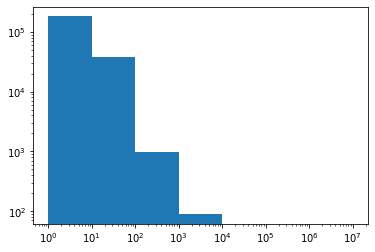

In [6]:
plt.figure()
plt.hist(ncount, bins=10**np.arange(8))
plt.xscale('log')
plt.yscale('log')
plt.show()

The vast majority has single-digit neighbors. Let

In [7]:
n_neighbors = 30
n_sources = len(t)
print(n_sources)

59146


Then simply

In [8]:
n_entries = n_neighbors * n_sources
print(n_entries)

1774380


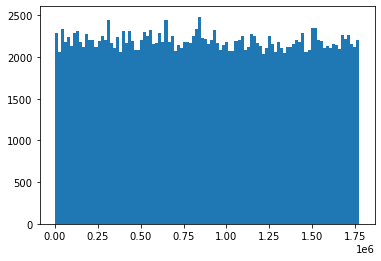

In [9]:
plt.figure()
plt.hist(nids % n_entries, bins=100)
plt.show()

When we take the module, the distribution is fairly uniform. This means the module operation can be useful for
an associative array.
We need

In [10]:
print('{:.2f} MiB'.format(t['NEIGHBOR_IDS'].nbytes / 1024 / 1024))

13.54 MiB


To store the full association. This has the disadvantage of not being in reference sample order (bad for photometry recomputation).
Multiply by 10 for a catalog with 500k sources, searching over it would be long.

The idea is to use an associative array with

In [11]:
associative_n = (n_neighbors + 1) * n_sources # Need a sentinel
size_entry = 8 * 3 # Reference ID + Object ID + Scale. Weight can go straight to the output.
print('{:.2f} MiB'.format((associative_n * size_entry)/1024/1024))

41.97 MiB


Not so bad, although we need some complication to avoid collisions. How many?

In [12]:
hashes = nids % associative_n
unique_hashes, count_hashes = np.unique(hashes, return_counts=True)
print('{:.2f} %'.format((len(hashes) - len(unique_hashes)) / len(hashes)))

0.13 %


In [24]:
alt_hash = np.array([hash(i) for i in nids]) % associative_n
unique_hashes, count_hashes = np.unique(alt_hash, return_counts=True)
print('{:.2f} %'.format((len(hashes) - len(unique_hashes)) / len(hashes)))

0.13 %


So 0.13% of collisions. Not so bad. There will be more since some reference objects can have more than one neighbor, but most don't.

How much for a dictionary?

In [13]:
%%time
ref_dict = dict()
for obj in t:
    for pos, n in enumerate(obj['NEIGHBOR_IDS']):
        if n not in ref_dict:
            ref_dict[n] = NeighborSet()
        ref_dict[n].append(obj['OBJECT_ID'], scale=1., distance=0.8, position=pos)

CPU times: user 15.7 s, sys: 267 ms, total: 15.9 s
Wall time: 16 s


In [14]:
sys.getsizeof(pickle.dumps(ref_dict)) / 1024 / 1024

156.04414749145508

That's 3 times. Of course, it is storing the distance and position, which are needed by the current implementation.

In [26]:
%%time
assoc = AssociativeArray(ref['ID'], n_sources, n_neighbors, [('scale', np.float32), ('distance', np.float32), ('position', np.int32)])
for obj in t:
    for pos, n in enumerate(obj['NEIGHBOR_IDS']):
        assoc.append(ref_id=n, source_id=obj['OBJECT_ID'], scale=1., distance=0.8, position=pos)

CPU times: user 20.7 s, sys: 104 ms, total: 20.8 s
Wall time: 20.8 s


In [27]:
(assoc._data.nbytes + assoc._ref_index.nbytes) / 1024 / 1024

47.23444747924805

In [28]:
for k in tqdm(list(assoc)):
    if k not in ref_dict:
        continue
    dn = ref_dict[k]
    an = assoc.get(k)
    assert len(dn) == len(an), (k, len(dn), len(an))
    assert set(dn.index) == set(an['object_id'])

  0%|          | 0/219305 [00:00<?, ?it/s]

In [ ]:
156.04/47.23